In [1]:
from utils import *
import episcanpy.api as epi
import time
import umap

2024-03-02 12:58:57.113590: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 12:58:57.136400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 12:58:57.447426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [2]:
file_path = '../data/E13_5-S1_atac.h5ad'

adata_raw = sc.read_h5ad(file_path)
adata_raw.obs['label'] = adata_raw.obs['Annotation_for_Combined']
print('load data: ', adata_raw)

epi.pp.filter_features(adata_raw, min_cells=1)
epi.pp.filter_cells(adata_raw, min_features=1)
num_all_peak = adata_raw.n_vars
print('data after pre-filtering: ', adata_raw)

load data:  AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes

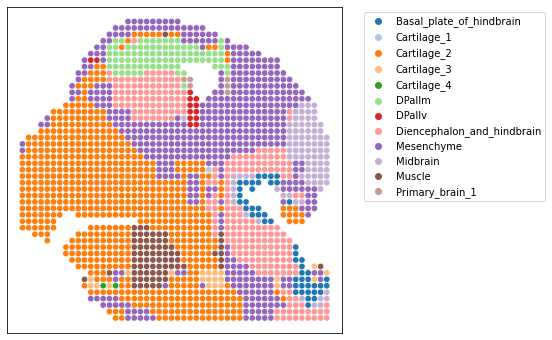

In [3]:
coord_x = np.array(adata_raw.obsm['spatial'][:,0])
coord_y = -np.array(adata_raw.obsm['spatial'][:,1])
plt.figure(figsize=(6, 6))
sns.scatterplot(x=coord_x, y=coord_y, hue=adata_raw.obs['label'], palette='tab20', s=40)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Set parameters

In [4]:
save_path = '../result/mouse_brain'
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_select_peak = 10000
seed_base = 1
tf = 'tfidf2'
pc = 10
k = 20
similarity = 'cosine'
iter_time = 4
spmethod = 'threshold'
neighbor = 5
sp_dist = 'recip'
pre_select = 'highest'
peaks_num = 50000
distance = 'euclidean'
r = 0.4

# Run Descartes

In [5]:
start_time = time.time()

adata = sc.AnnData(adata_raw.X,dtype = 'float32')
idx, sorted_index, simi_matrix, idx_all, scores, selected_peaks_data,similarity_matrix_acb, similarity_matrix_spatial = run_descartes(adata_raw, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")

AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

# Save the results

In [6]:
result = pd.DataFrame({'idx':idx})
filename = save_path + '/Descartes.csv'
result.to_csv(filename,header=True)

In [7]:
current_pid = os.getpid()
peak_memory = get_peak_memory_usage(current_pid)
run_time = end_time - start_time
meta = pd.DataFrame({'Peak memory':[peak_memory], 'run time':[run_time]})
meta.to_csv(save_path + '/Descartes_meta.csv',index=None)

# Analysis

## Overlap with domain-specific peaks identified by epiScanpy

In [8]:
sparse_matrix = scipy.sparse.csr_matrix(adata_raw.X)
adata_temp = anndata.AnnData(X=sparse_matrix)
adata_temp.obs['label'] = list(adata_raw.obs['Annotation_for_Combined'])
adata_temp.var_names = adata_raw.var_names
label = np.array(adata_temp.obs['label'])
label[np.where(label == 'Cartilage_1')[0]] = 'Cartilage_2'
adata_temp.obs['label'] = label
adata_temp.X = sc.pp.log1p(adata_temp.X)
adata_temp.raw = adata_temp
epi.tl.rank_features(adata_temp, 'label')
adata_temp


    			When the parameters where not specified in input


AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'label'
    uns: 'rank_features_groups'

In [9]:
a = np.array(adata_temp.uns['rank_features_groups']['names'].tolist())
domains = list(adata_temp.uns['rank_features_groups']['names'].dtype.names)
c = pd.DataFrame(a,columns=domains)
d = []
for domain in domains:
    b = list(c[domain])
    d.append(list(adata_raw.var_names.get_indexer(b)))
d = pd.DataFrame(np.array(d).T,columns=domains)
c, d

(    Basal_plate_of_hindbrain                Cartilage_2  \
 0       chr7:4123629-4124130   chr4:124708675-124709176   
 1     chr7:79525769-79526270    chr10:80260940-80261441   
 2   chr3:108433510-108434011     chr2:32317962-32318463   
 3   chr2:150643943-150644444    chr17:39843120-39843621   
 4     chr6:91301763-91302264   chr9:106356245-106356746   
 ..                       ...                        ...   
 95  chr8:124284228-124284729    chr11:74832081-74832582   
 96  chr4:154948216-154948717   chr7:113513425-113513926   
 97      chr1:5023194-5023695     chr5:34187588-34188089   
 98    chr1:34583718-34584219  chr11:109011651-109012152   
 99  chr4:140658105-140658606      chr19:8966769-8967270   
 
                   Cartilage_3               Cartilage_4  \
 0      chr2:33977596-33978097    chr7:37496483-37496984   
 1     chr11:38060130-38060631   chr16:77754716-77755217   
 2    chr2:172844886-172845387  chr5:135442428-135442929   
 3       chr16:8871329-8871830   chr15

In [10]:
overlap = []
for domain in domains:
    a = c[domain]
    b = d[domain]
    overlap.append(np.intersect1d(np.array(idx), b).size / len(a))
result = pd.DataFrame({'domain':domains,'overlap':overlap})
result

,domain,overlap
0,Basal_plate_of_hindbrain,0.98
1,Cartilage_2,0.97
2,Cartilage_3,0.03
3,Cartilage_4,0.04
4,DPallm,0.93
5,DPallv,0.46
6,Diencephalon_and_hindbrain,0.56
7,Mesenchyme,0.83
8,Midbrain,0.85
9,Muscle,0.90


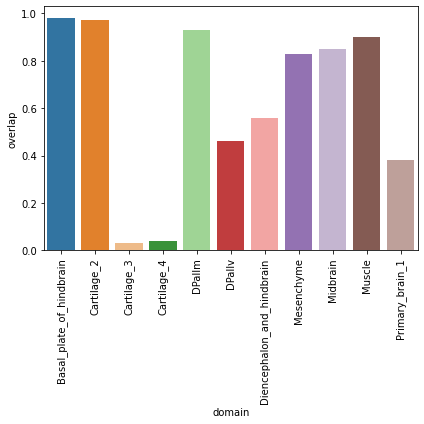

In [11]:
colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94']
sns.set_palette(colors)
plt.figure(figsize=(6, 6))
sns.barplot(x='domain', y='overlap',data=result)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Clustering

In [12]:
num_all_peak = adata_raw.n_vars

count = tfidf2(adata_raw.X.todense().T).T
print(count.shape)

count_filter = count[:,idx]
count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(np.array(count_filter))
adata_pca = sc.AnnData(scipy.sparse.csc_matrix(count_filter),dtype = 'float32')
adata_pca.obs['label'] = list(adata_raw.obs['label'])

sc.pp.neighbors(adata_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
leiden_df = run_leiden(adata_pca,'label','cluster',seed=int(seed_base*1000))

leiden_df

(1777, 271126)
Clustering...
resolution: 0.1, NMI: 0.4812918873946111, ARI: 0.5426417695676197, Homo: 0.39402373096918775, AMI: 0.47877244034495325
resolution: 0.2, NMI: 0.5069968824472592, ARI: 0.39091636392435297, Homo: 0.5207145161675039, AMI: 0.501658982269791
resolution: 0.3, NMI: 0.4805971233149587, ARI: 0.2910632249667228, Homo: 0.5366214804525727, AMI: 0.47374720645974217
resolution: 0.4, NMI: 0.5003872898447786, ARI: 0.3182760110840682, Homo: 0.5669231004232631, AMI: 0.4931753000547969
resolution: 0.5, NMI: 0.47723649527141515, ARI: 0.2630050703825569, Homo: 0.5671639329707595, AMI: 0.4685184541668516
resolution: 0.6, NMI: 0.47710296714550626, ARI: 0.24850035388497296, Homo: 0.5768958516618459, AMI: 0.46846519413964516
resolution: 0.7, NMI: 0.4918109302703362, ARI: 0.24555584198406158, Homo: 0.6199730858041148, AMI: 0.48173250672467194
resolution: 0.8, NMI: 0.483638423719809, ARI: 0.2318242604611739, Homo: 0.6193165396071002, AMI: 0.472885004207663
resolution: 0.9, NMI: 0.4785

,resolution,NMI,ARI,Homo,AMI
0,0.2000,0.506997,0.390916,0.520715,0.501659
1,0.5625,0.489992,0.268630,0.586715,0.481510
2,0.1000,0.481292,0.542642,0.394024,0.478772
3,0.2000,0.506997,0.390916,0.520715,0.501659
4,0.3000,0.480597,0.291063,0.536621,0.473747
5,0.4000,0.500387,0.318276,0.566923,0.493175
6,0.5000,0.477236,0.263005,0.567164,0.468518
7,0.6000,0.477103,0.248500,0.576896,0.468465
8,0.7000,0.491811,0.245556,0.619973,0.481733
9,0.8000,0.483638,0.231824,0.619317,0.472885


In [13]:
adata_pca.obsm['spatial'] = adata_raw.obsm['spatial']
sc.pp.neighbors(adata_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
leiden_df = run_leiden_(adata_pca,'label','cluster',seed=int(seed_base*1000),n_cluster=np.unique(adata_raw.obs['label']).shape[0])
sc.pp.neighbors(adata_pca, n_neighbors=90, use_rep='spatial',random_state=seed_base*1000)

adata_pca.obsm['X_emb'] = scipy.sparse.csc_matrix(count_filter)
LISI = lisi_graph_py(adata=adata_pca, group_key='cluster')    
print('LISI:',np.median(LISI))

CHAOS = fx_CHAOS(np.array(adata_pca.obs['cluster'],dtype=int),np.array(adata_pca.obsm['spatial']))
print('CHAOS:',CHAOS)

PAS = fx_PAS(np.array(adata_pca.obs['cluster'],dtype=int),np.array(adata_pca.obsm['spatial']))
print('PAS:',PAS)

Clustering...
LISI: 3.410472060494635
CHAOS: 0.0886324843882515
PAS: 0.34440067529544177


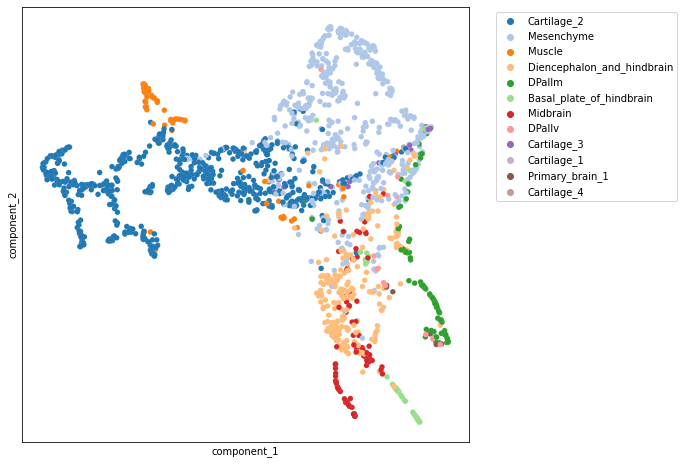

In [14]:
label = adata_pca.obs['label']
proj = umap.UMAP().fit_transform(count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'component_1':proj[:, 0],\
    'component_2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="component_1", y="component_2", hue="label",palette = 'tab20', s=30,linewidth = 0.05, data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([])
plt.yticks([])
plt.show()